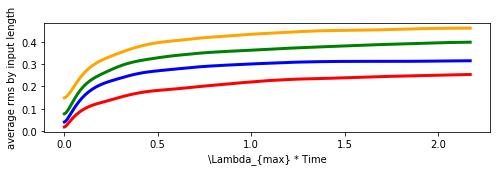

In [34]:
DMD_2bit = np.load('DMD_Nres_1000_2bit/DMD_Nres_1000_2bit.npy')
DMD_4bit = np.load('DMD_Nres_1000_4bit/DMD_Nres_1000_4bit.npy')
DMD_6bit = np.load('DMD_Nres_1000_6bit/DMD_Nres_1000_6bit.npy')
DMD_8bit = np.load('DMD_Nres_1000_8bit/DMD_Nres_1000_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:DMD_2bit.shape[0]]*lyap_exp_max, DMD_2bit, color='orange', linewidth=3.0)
plt.plot(tt[:DMD_4bit.shape[0]]*lyap_exp_max, DMD_4bit, color='green', linewidth=3.0)
plt.plot(tt[:DMD_6bit.shape[0]]*lyap_exp_max, DMD_6bit, color='blue', linewidth=3.0)
plt.plot(tt[:DMD_8bit.shape[0]]*lyap_exp_max, DMD_8bit, color='red', linewidth=3.0)
plt.savefig('DMD_encoding_depth_dependence.png')
plt.show;

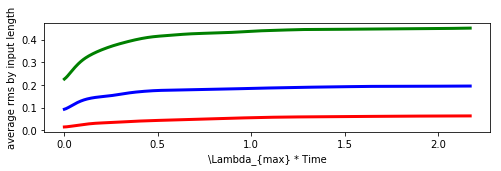

In [33]:
SLM_Nres_10000 = np.load('SLM_Nres_10000/SLM_8bit.npy')
SLM_Nres_1000 = np.load('SLM_Nres_1000/SLM_8bit.npy')
SLM_Nres_100 = np.load('SLM_Nres_100/SLM_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:SLM_Nres_10000.shape[0]]*lyap_exp_max, SLM_Nres_10000, color='red', linewidth=3.0)
plt.plot(tt[:SLM_Nres_1000.shape[0]]*lyap_exp_max, SLM_Nres_1000, color='blue', linewidth=3.0)
plt.plot(tt[:SLM_Nres_100.shape[0]]*lyap_exp_max, SLM_Nres_100, color='green', linewidth=3.0)
plt.savefig('SLM_Nres_dependence.png')
plt.show;

In [2]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data

%load_ext autoreload
%autoreload 1
%aimport data
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
roll_num = 30
spatial_points = 64
enc_depth = 8
n_res = 8000
b = Reservoir(n_res=n_res, input_scale=2, train_method='ridge', train_param=2000,
              weights_type='complex gaussian', random_projection='simulation',
              activation_fun='phase_8bit', activation_param=1,encoding_method='phase', 
              encoding_param=1, input_dim=spatial_points+1, forget=100) 
#(2**enc_depth)*spatial_points spatial_points+1

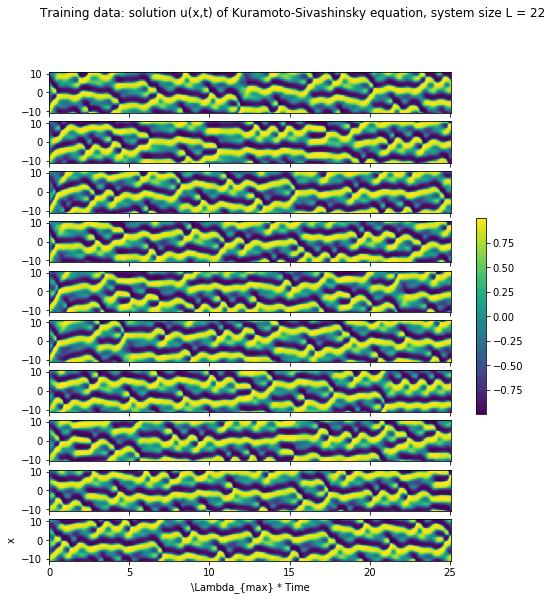

In [13]:
# calculate training data
n_sequence=10
ks_data, xx_, tt_ = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=n_sequence, 
                                              spatial_points=spatial_points)
tt = np.linspace(np.amin(tt_), np.amax(tt_), tt_.shape[2])
xx = xx_[0,:,0]
lyap_exp = data.kuramoto_sivashinsky_lyap_exp(sequence_length=100, n_sequence = 100, spatial_points=20)

# plot training data
fig, axs = plt.subplots(n_sequence, 1, sharex=True, figsize=(9,9))
plt.suptitle('Training data: solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)
for i in range(n_sequence):
    im=axs[i].pcolormesh(tt*lyap_exp, xx, ks_data[i, :,:].T, cmap='viridis')

In [ ]:
# Algorithm training
y = data.roll_and_concat(ks_data, roll_num=roll_num)
b.fit(ks_data, y)

Start of training...
Initialization finished. Elapsed time:
4.890552282333374
 83%|████████▎ | 1659/2001 [01:08<00:14, 24.12it/s]

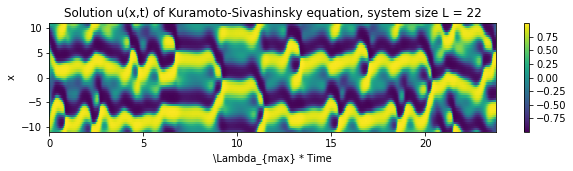

In [5]:
# calculate testing data
ks_data, _, _ = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=1, spatial_points=spatial_points)

# plot testing data
plt.figure(1,figsize=(10,2))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(tt*lyap_exp, xx, ks_data[0, :,:].T, cmap='viridis')
plt.colorbar(im)

In [6]:
# Algorithm testing
y = data.roll_and_concat(ks_data, roll_num=roll_num)[:, b.forget:, :]
y_target = y.reshape(-1, y.shape[-1])
pred_output, valid_score = b.score(ks_data, y_target)

Start of testing...
Initialization finished. Elapsed time:
0.004925966262817383
100%|██████████| 2001/2001 [02:00<00:00, 16.65it/s]
Iterations finished. Elapsed time:
120.18372082710266
Testing finished. Elapsed time:
122.27694606781006
Testing finished. Elapsed time:
129.29899716377258
Testing score:
0.541357314065136


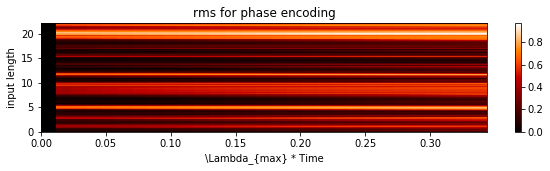

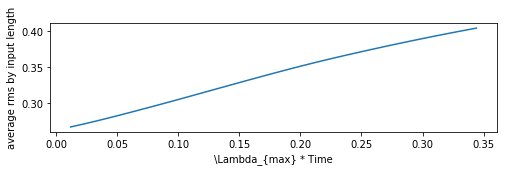

In [7]:
# prediction RMSE

length_input = pred_output.shape[0]-roll_num
rms = np.zeros((length_input, roll_num))
for n_input in range(1, length_input):
    for n_pred in range(1, roll_num):
        d1 = pred_output[n_input, :].reshape(-1, spatial_points+1)[0:n_pred,:]
        d2 = y_target[n_input:n_input+n_pred, 0:spatial_points+1]
        
        rms[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))


time_input = tt[0:n_input+1]*lyap_exp
time_pred = tt[0:roll_num]*lyap_exp

plt.figure(1,figsize=(10,2))
plt.title('rms for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred, time_input, rms[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[1:], np.sum(rms[:,1:], axis=0)/length_input)
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rms[:,1:], axis=0)/length_input)

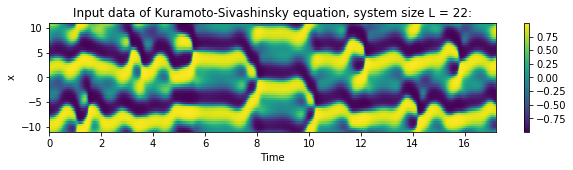

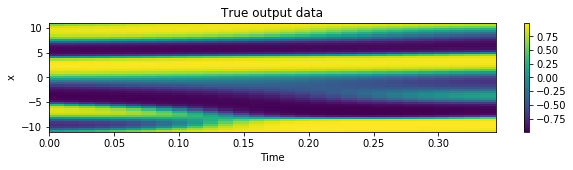

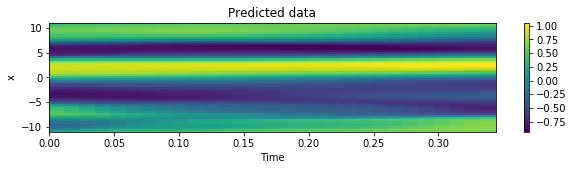

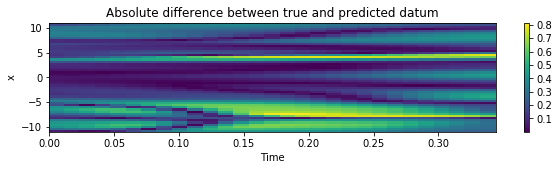

In [19]:
n_input = 1450 #round(pred_output.shape[0]/2-300)

input_data = y_target[0:n_input, 0:spatial_points+1]

prediction = np.zeros((roll_num, spatial_points + 1))
for i in range(roll_num):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
    
targetted_data = y_target[n_input:n_input+roll_num, 0:spatial_points+1]

time = tt[0:n_input+roll_num]*lyap_exp
vmax = max(abs(np.concatenate((prediction,targetted_data,input_data)).flatten()))
vmin = -vmax

fig1 = plt.figure(1, figsize=(10,2))
plt.title('Input data of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:n_input], xx, input_data.T, cmap='viridis')
plt.colorbar(im)
# plt.savefig('DND_input_data.png')

fig2 = plt.figure(2, figsize=(10,2))
plt.title('True output data')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, targetted_data.T, cmap='viridis')
plt.colorbar(im)
# plt.savefig('DMD_true_data.png')

fig3 = plt.figure(3, figsize=(10,2))
plt.title('Predicted data')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, prediction.T, cmap='viridis')
plt.colorbar(im)
# plt.savefig('DMD_predicted_data.png')

fig4 = plt.figure(4, figsize=(10,2))
plt.title('Absolute difference between true and predicted datum')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, np.abs((targetted_data-prediction).T), cmap='viridis')
plt.colorbar(im)
# plt.savefig('DMD_true_predicted_difference.png')

<function matplotlib.pyplot.show(*args, **kw)>

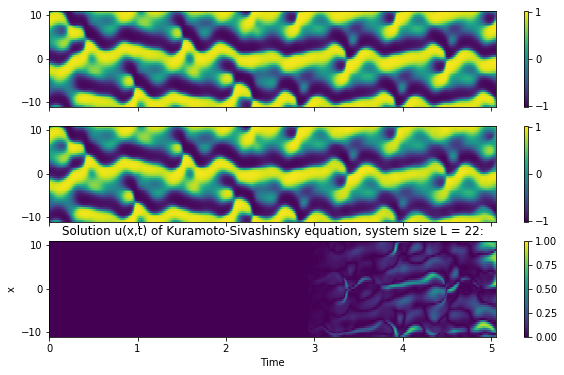

In [34]:
n_input = 690 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((roll_num, spatial_points + 1))
for i in range(roll_num):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+roll_num, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+roll_num, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+roll_num]*lyap_exp_max
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+roll_num, 0:spatial_points+1].T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+roll_num, 0:spatial_points+1].T-all_data.T), cmap='viridis', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[2])
plt.show